In [10]:
# default_exp loaders

# Datasets, DataLoaders, Samplers

In [11]:
from nbdev import *

In [12]:
# export

import random
import numpy as np
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader

In [13]:
from lunglens.data import *

### Basic dataset

Generates specified number of slices from one scans per one item. Length of the dataset is equal to the number of scans

In [14]:
# export

default_dict = {
    'slices_per_scan': 4,
    'inter_slice_distance': 40
}

class RandomSlicerDataset(Dataset):
    def __init__(self, datasets_root, config=default_dict):
        self.scans = list(datasets_root.glob('*/*'))
        self.config = config
        self.slices_cache = {}

    def __len__(self):
        return len(self.scans)

    def __getitem__(self, idx):
        # idx can be an indexing slice or an index
        if isinstance(idx, slice):
            idx_range = range(len(self))[idx]
            
            return [self.get_item(idx) for idx in idx_range]
        else:
            return self.get_item(idx)
    
    def get_item(self, idx):
        scan_dir = self.scans[idx]

        if str(scan_dir) not in self.slices_cache:
            self.slices_cache[scan_dir] = list(scan_dir.glob('*.npy'))

        # TODO: add smart slices sampling
        random_slices = random.sample(
            self.slices_cache[scan_dir],
            self.config['slices_per_scan'])

        return np.stack([np.load(str(s)) for s in random_slices])

In [15]:
datasets_root = Path('../data/prepared')
dataset = RandomSlicerDataset(datasets_root)
len(dataset)

1285

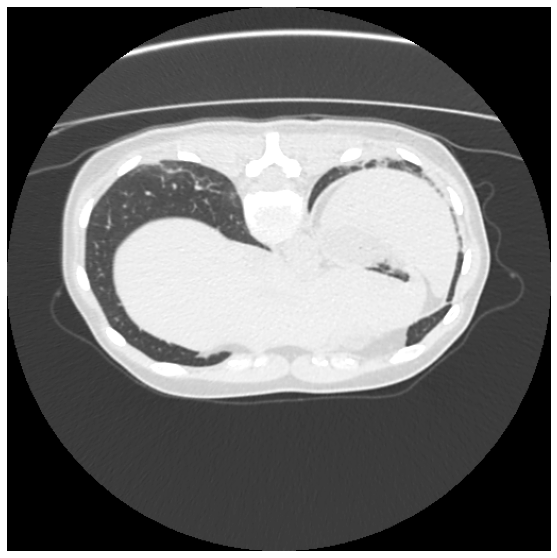

In [16]:
print_slice(random.choice(random.choice(dataset)))

#### Checking if caching is working
Enumerating the dicrectory is cached but slices loading is not because datasets are too big

In [17]:
%%time
for slices_batch in dataset[:10]:
    pass

Wall time: 144 ms


In [18]:
%%time
for slices_batch in dataset[:10]:
    pass

Wall time: 165 ms


#### Testing with default dataloader

In [19]:
batch_size = 8

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

#### Optionally we can squash per-scan batches into one batch

In [20]:
# export

def squash_scan_batches(superbatch):
    shape = list(superbatch.shape)
    
    # slices from all scans and all batches go to single batch
    shape[1] = shape[1] * shape[0]
    shape[0] = 1
    
    return superbatch.view(*shape)


In [21]:
squash_scans = True

In [29]:
for superbatch in loader:
    break

In [30]:
type(superbatch), superbatch.shape

(torch.Tensor, torch.Size([8, 4, 512, 512]))

In [31]:
if squash_scans:
    shape = list(superbatch.shape)
    reshaped_batch = squash_scan_batches(superbatch)
    print(reshaped_batch.shape)

torch.Size([1, 32, 512, 512])


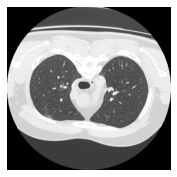

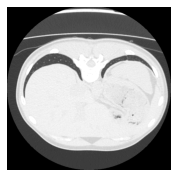

In [32]:
print_slice(superbatch[0][1], figsize=(3, 3))
print_slice(superbatch[1][1], figsize=(3, 3))

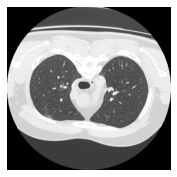

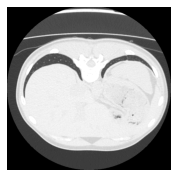

In [33]:
print_slice(reshaped_batch[0][1], figsize=(3, 3))
print_slice(reshaped_batch[0][4 + 1], figsize=(3, 3))